## Model selection

### Topics

Out of scope: [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering); we assume we already have good enough features.

### DRY-violation warning

Note: the code below is to demonstrate the model selection pipeline of [risk_learning/model_selection/run-pipeline.py](..risk_learning/model_selection/run-pipeline.py), in violation of the DRY or [Do Not Repeat Yourself](https://en.wikipedia.org/wiki/Don't_repeat_yourself) principle.

See this repository's [commit history](https://github.com/munichpavel/risk-ai-workshop/commits/main), especially the [before](https://github.com/munichpavel/risk-ai-workshop/tree/ddbf4e07f25a51796bf5871bd595cefd8f870ba7/notebooks/model-selection-examples.ipynb) and [after](https://github.com/munichpavel/risk-ai-workshop/blob/2777d1ec4ab3fd9a3376fbdee3597dc2de1e38f1/notebooks/model-selection-examples.ipynb) commits of this notebook for examples of errors resulting from DRY violations.

In [1]:
import os
from pathlib import Path

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import xarray as xr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import average_precision_score

from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from fake_data_for_learning.contingency_tables import calculate_contingency_table

from risk_learning.simpson import (
    get_flat_combinations, 
    make_feature_combination_score_array,
    compute_margin
)

In [2]:
data_dir = Path(os.getcwd()) / 'data'

file_read_params = dict(delimiter=',')
target_col = 'default'
non_target_cols = ['gender', 'occupation', 'activity']
#non_target_cols = ['gender']
df = pd.read_csv(
    data_dir / 'default.csv', **file_read_params,
    usecols=non_target_cols + [target_col]
)
print(f'Shape of entire dataset: {df.shape}')
df.head()

Shape of entire dataset: (10000, 4)


,gender,occupation,activity,default
0,1,0,0,1
1,0,0,0,0
2,0,0,1,1
3,0,0,0,0
4,0,1,0,0


## Split data for model fitting

In [3]:
train_ratio = 0.4
test_ratio = 0.2

seed = 42
X = df[non_target_cols]
y = df[target_col]

# Split into train + validation  / test sets
X_train_validate, X_test, y_train_validate, y_test = train_test_split(
    X, y, test_size=test_ratio, random_state=seed
)

train_ratio_after_test_split = train_ratio / (1 - test_ratio)
X_train, X_validate, y_train, y_validate = train_test_split(
    X_train_validate, y_train_validate,
    train_size=train_ratio_after_test_split,
    random_state=seed
)

### A little Exploratory Data Analysis

Very little.

In [4]:
# Value ranges can be guessed from data or extracted from IT system
default_values = [0, 1]
gender_values = [0, 1]
occupation_values = [0, 1]
activity_values = [0, 1]
data_categories = dict(
    default=CategoricalDtype(categories=default_values, ordered=True),
    gender=CategoricalDtype(categories=gender_values, ordered=True),
    occupation=CategoricalDtype(categories=occupation_values, ordered=True),
    activity=CategoricalDtype(categories=activity_values, ordered=True)
)

# Recombine 
X_y_train = X_train.copy()
X_y_train['default'] = y_train.values
for column, c_type in data_categories.items():
    X_y_train[column] = X_y_train[column].astype(c_type)
    
contingency_table = calculate_contingency_table(X_y_train[data_categories.keys()])

In [5]:
female_default_rate = (
    compute_margin(contingency_table, dict(default=1, gender=0 )) 
    / compute_margin(contingency_table, dict(gender=0))
)
print('\nfemale empirical default rate', female_default_rate)
male_default_rate = (
    compute_margin(contingency_table, dict(default=1, gender=1)) 
    / compute_margin(contingency_table, dict(gender=1))
)
print('male empirical default rate', male_default_rate)


female empirical default rate 0.4262125902992776
male empirical default rate 0.3055286129970902


In [6]:
pairs = [('gender', 'default'), ('activity', 'default'), ('occupation', 'activity')]
for pair in pairs:
    print(f'Correlation of {pair}: {pearsonr(X_y_train[pair[0]], X_y_train[pair[1]])}')

Correlation of ('gender', 'default'): (-0.1253520931713313, 1.7642213981560552e-15)
Correlation of ('activity', 'default'): (0.00314023743974586, 0.8426190949871257)
Correlation of ('occupation', 'activity'): (0.13110356292731065, 8.427126908872454e-17)


In [7]:
# Other variables uses when evaluating different models
gender_values = [0, 1]
occupation_values = [0, 1]
activity_values = [0, 1]
feature_coords = dict(
    gender=gender_values,
    occupation=occupation_values,
    activity=activity_values
)
feature_combinations = get_flat_combinations(feature_coords)

## Fit models to training data and spot-check on validation data

In [8]:
first_n = 5
idxes_first_n = X_validate.index[:first_n]
X_validate_first_n = X_validate.loc[idxes_first_n, :]
y_validate_first_n = y_validate[:first_n]
sample_validate = X_validate_first_n.copy()
sample_validate['default'] = y_validate_first_n
sample_validate

,gender,occupation,activity,default
3188,0,1,0,0
8293,0,0,1,1
1710,0,0,0,0
7510,0,1,0,0
1461,0,0,0,0


## Logistic regression

In [9]:
hyperparams = {"C": 0.5, "random_state": 42}
clf = LogisticRegression(**hyperparams)
clf.fit(X_train, y_train)
clf.predict_proba(X_validate_first_n)

array([[0.74648263, 0.25351737],
       [0.50460374, 0.49539626],
       [0.5438054 , 0.4561946 ],
       [0.74648263, 0.25351737],
       [0.5438054 , 0.4561946 ]])

In [10]:
scores = clf.predict_proba(X_validate)
default_scores = scores[:, 1]
average_precision_score(y_validate, default_scores)

0.6574460339050116

In [11]:
# Default scores by gender
scores = clf.predict_proba(feature_combinations)[:, 1]
score_array = make_feature_combination_score_array(feature_combinations, scores)
mean_female_score = score_array.sel(gender=0).mean().values
mean_male_score = score_array.sel(gender=1).mean().values
print(clf.__class__, 'mean scores')
print(f'female: {mean_female_score}, male: {mean_male_score}')

<class 'sklearn.linear_model._logistic.LogisticRegression'> mean scores
female: 0.3723799137508855, male: 0.3495278862382101


## Decision tree

In [12]:
hyperparams = {"criterion": "gini", "random_state": 42}
clf = DecisionTreeClassifier(**hyperparams)
clf.fit(X_train, y_train)
clf.predict_proba(X_validate_first_n)

array([[1.        , 0.        ],
       [0.04871448, 0.95128552],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [13]:
scores = clf.predict_proba(X_validate)
default_scores = scores[:, 1]
average_precision_score(y_validate, default_scores)

0.9403815509592428

In [14]:
# Default scores by gender
scores = clf.predict_proba(feature_combinations)[:, 1]
score_array = make_feature_combination_score_array(feature_combinations, scores)
mean_female_score = score_array.sel(gender=0).mean().values
mean_male_score = score_array.sel(gender=1).mean().values
print(clf.__class__, 'mean scores')
print(f'female: {mean_female_score}, male: {mean_male_score}')

<class 'sklearn.tree._classes.DecisionTreeClassifier'> mean scores
female: 0.4799473644955409, male: 0.4727199392616494


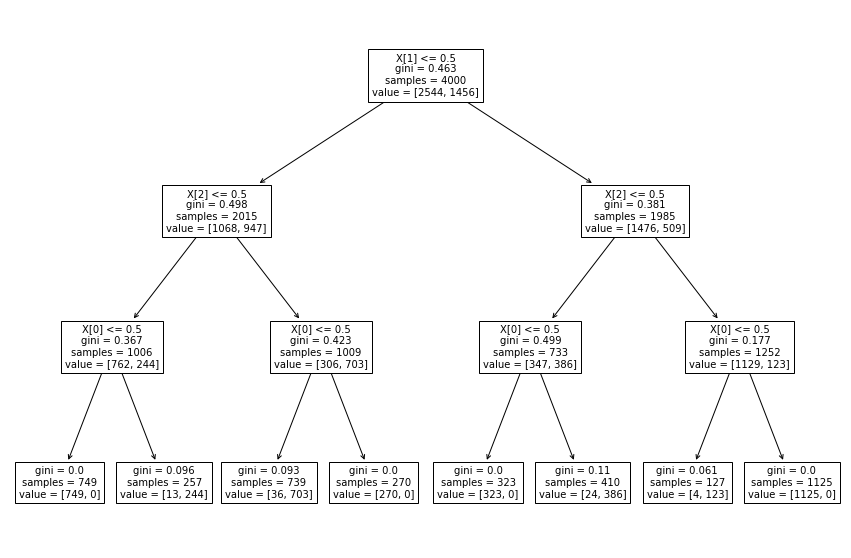

In [15]:
plt.figure(num=None,figsize=(15,10))
tree.plot_tree(clf, fontsize=10)
plt.show()

### Random Forest Classifier

In [16]:
hyperparams = {"n_estimators": 5, "random_state": 42}
clf = RandomForestClassifier(**hyperparams)
clf.fit(X_train, y_train)
clf.predict_proba(X_validate_first_n)

array([[1.        , 0.        ],
       [0.05070054, 0.94929946],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [17]:
scores = clf.predict_proba(X_validate)
default_scores = scores[:, 1]
average_precision_score(y_validate, default_scores)

0.9411775941217513

In [18]:
# Default scores by gender
scores = clf.predict_proba(feature_combinations)[:, 1]
score_array = make_feature_combination_score_array(feature_combinations, scores)
mean_female_score = score_array.sel(gender=0).mean().values
mean_male_score = score_array.sel(gender=1).mean().values
print(clf.__class__, 'mean scores')
print(f'female: {mean_female_score}, male: {mean_male_score}')

<class 'sklearn.ensemble._forest.RandomForestClassifier'> mean scores
female: 0.4817980094553979, male: 0.4743419826628372
